**Modeling Analysis for Canalyst**

*Sample Notebook*

10/10/2021

Maintainer: jed.gore@canalyst.com

<span style='color:#00838F'>**This notebook is intended as an example of a workflow highlighting the use of candas_datareader**</span>

Please request an api key at:
https://app.canalyst.com/settings/api-tokens

In [1]:
import sys
import os
import dtale
import dtale.app as dtale_app
dtale_app.JUPYTER_SERVER_PROXY = True
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import canalyst_candas.candas as cd
import canalyst_candas.candas_datareader as cdr
from canalyst_candas.configuration.config import Config
config_info = {
  "canalyst_api_key": "",
  "s3_access_key_id": "",
  "s3_secret_key": "",
  "fred_key": "",
  "default_dir": "",
  "mds_host": "",
  "wp_host": ""
}
config = Config(config=config_info)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

A configuration file has been created for you in 
/home/canalyst-candas/canalyst/keys.json. For Excel file downloads and scenario 
mapping, you'll need to add an API key to the 'canalyst_api_key' 
value. Visit https://app.canalyst.com/settings/api-tokens to create 
and retrieve your API key. You will also need to retrieve your 
S3 Access ID and Secret Key and fill in 'canalyst_s3_id' and 
'canalyst_s3_key' with those values, respectively. If using a 
Jupyter Notebook, stop and restart the notebook for the changes to 
take effect. If using a Python/iPython session, quit the current 
session and start a new one.


<b>Key Parameters</b>

Establish our price ticker (data source yahoo finance) and our Canalyst ticker (we use Bloomberg ticker format)

In [2]:
ticker = "V US"
yahoo_ticker = "V" #need this for prices
index_ticker = "^GSPC" #this is our benchmark index (^GSPC for S&P 500, EFA for msci eafa etc)
alpha_days = "alpha_1_day" #or alpha_5_day or alpha_10_day
regression_window = 12
model_set = cd.ModelSet(ticker_list=[ticker], config=config) #create a modelset of our ticker

Check whether we cover this stock

In [3]:
#instantiate a search object, which we will also use later
search = cd.Search(config)
search.get_ticker_list(ticker = ticker) #do we cover this stock?

,File,Bloomberg Ticker,Thomson Ticker
2715,Visa V US,V US,V.N


Let's take a look at the list of available segments (categories) in the model.

In [4]:
categories = list(model_set.model_frame(ticker=ticker,
                      period_duration_type = "fiscal_quarter", 
                      mrq=True)['category'].unique())
categories

['Growth Analysis',
 'Segmented Results - Revenue Breakdown (FS)',
 'Operating Stats - Consolidated Operational Data',
 'Segmented Results - Geographic Revenue Breakdown (FS)',
 'Operating Stats - Nominal Payments Volumes (FS & IP)',
 'Operating Stats - Processed Transactions (Operational Data)',
 'Operating Stats - US (Operational Data)',
 'Operating Stats - International (Operational Data)',
 'Key Metrics - International - By Geography (Operational Data)',
 'Key Metrics - Cash Volume & Transactions (Operational Data)',
 'Key Metrics - Total Volume (Operational Data)',
 'Key Metrics - Payments Revenue and Take Rate',
 'Key Metrics - Employee Count (FS)',
 'Margin Analysis',
 'Income Statement As Reported',
 'Adjusted Numbers As Reported',
 'Revised Income Statement',
 'Cash Flow Summary',
 'Balance Sheet Summary',
 'Valuation',
 'Cumulative Cash Flow Statement',
 'Cash Flow Statement',
 'Working Capital Forecasting',
 'D&A Forecasting',
 'Balance Sheet']

Goal: Create a pivoted view of one category of the model_frame

In [5]:
model_set.model_frame(ticker=ticker,
                      category=categories[0], #filter to one or more category
                      period_duration_type = "fiscal_quarter", #only fiscal quarters
                      is_historical=True, #historical data only
                      pivot=True, #pivot the data so dates are on column headers
                     n_periods=regression_window).head()

period_name_sorted,ticker,name_index,category,time_series_name,time_series_description,is_driver,MRFQ,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4
0,V US,7,Growth Analysis,z_2CRCA60110_MO_OS_servicerevenuesgrowth,"Service revenues growth, %",False,Q4-2021,9.13327,7.27918,9.51730,9.16918,9.09479,8.52296,0.16632,-12.57886,4.77495,8.46359,17.39311,40.95625
1,V US,8,Growth Analysis,z_2CRCA60110_MO_OS_dataprocessingrevenuesgrowth,"Data processing revenues growth, %",False,Q4-2021,15.04425,14.33945,12.84443,15.66416,15.95142,11.47204,-5.14651,3.82810,5.90084,10.51273,31.76238,19.51304
2,V US,9,Growth Analysis,z_2CRCA60110_MO_OS_internationaltransactionrevenuesgrowth,"International transaction revenues growth, %",False,Q4-2021,11.10444,2.51142,8.03279,11.05451,9.02215,2.06013,-44.25898,-38.25688,-28.09713,-18.82160,53.90200,40.78752
3,V US,10,Growth Analysis,z_2CRCA60110_MO_OS_Otherrevenuesgrowth,"Other revenues growth, %",True,Q4-2021,30.56769,42.17391,49.34498,34.76562,22.07358,19.87768,-8.18713,4.63768,5.20548,0.00000,30.25478,35.73407
4,V US,11,Growth Analysis,z_2CRCA60110_MO_OS_clientincentivesgrowth,"Client incentives growth, %",False,Q4-2021,9.80392,14.66253,12.51820,12.71638,20.05495,15.35859,-2.13454,0.29533,6.29291,16.83284,40.77991,40.57715


Next we set up a dataset which includes:
- a full modelframe of quarterly data 
- a set of earnings data, 
- rolling 252 day beta vs the S&P 500
- 1 and 5 and 10 day alpha (excess beta adjusted performance vs the S&P 500)

In [6]:
df_data = model_set.pe_dataset(ticker,yahoo_ticker,index_ticker)

In a separate example, we can:
    <br>- pull just the earnings and prices dataframe for this ticker 
    <br>- chart earnings surprise vs stock movement

In [7]:
df = cdr.get_earnings_and_prices(yahoo_ticker,index_ticker = index_ticker) 

In [8]:
df.tail()

,ticker,earnings_date,companyshortname,price_date,epsestimate,epsactual,epssurprisepct,alpha_1_day,alpha_5_day,alpha_10_day,beta_252,plus_1_return,plus_5_return,plus_10_return,mktclose_plus_1_return,mktclose_plus_5_return,mktclose_plus_10_return
47,V,2020-10-28,Visa Inc.,2020-10-28,1.09000,1.12000,2.94000,0.00880,0.01367,0.07319,1.11471,0.02212,0.07243,0.17598,0.01195,0.05271,0.09221
48,V,2021-01-28,Visa Inc.,2021-01-28,1.28000,1.42000,11.20000,-0.00338,0.03063,0.02615,1.12323,-0.02507,0.05565,0.06441,-0.01931,0.02227,0.03406
49,V,2021-04-27,Visa Inc.,2021-04-27,1.27000,1.38000,8.66000,0.01630,0.01487,-0.01040,1.07300,0.01540,0.00922,-0.01927,-0.00085,-0.00527,-0.00827
50,V,2021-07-27,Visa Inc.,2021-07-27,1.35000,1.49000,10.21000,-0.01570,-0.06041,-0.05980,1.06609,-0.01590,-0.05515,-0.05125,-0.00019,0.00493,0.00802
51,V,2021-10-26,Visa Inc.,2021-10-26,1.54000,1.62000,5.06000,-0.06347,-0.11167,-0.10685,1.13271,-0.06919,-0.09783,-0.07950,-0.00505,0.01221,0.02415


We can use pandas' describe() function to get the mean eps surprise and subsequent stock movement for this stock.

In [9]:
df.describe().reset_index() #row 2 is the mean of the full series of data

,index,epsestimate,epsactual,epssurprisepct,alpha_1_day,alpha_5_day,alpha_10_day,beta_252,plus_1_return,plus_5_return,plus_10_return,mktclose_plus_1_return,mktclose_plus_5_return,mktclose_plus_10_return
0,count,52.00000,52.00000,52.00000,48.00000,48.00000,48.00000,48.00000,52.00000,52.00000,52.00000,52.00000,52.00000,52.00000
1,mean,0.70346,0.74135,5.50212,0.00298,0.00412,0.01112,1.06090,0.00628,0.01060,0.01974,0.00065,0.00294,0.00330
2,std,0.41213,0.43410,4.97341,0.03079,0.04223,0.04159,0.12814,0.03686,0.05027,0.05857,0.01238,0.02234,0.03600
3,min,0.16000,0.17000,-1.43000,-0.06347,-0.11167,-0.10685,0.67070,-0.06919,-0.09783,-0.09652,-0.03114,-0.08539,-0.14111
4,25%,0.36000,0.38500,2.29000,-0.01717,-0.01817,-0.01317,0.95640,-0.01932,-0.02285,-0.01812,-0.00433,-0.00830,-0.01538
5,50%,0.62000,0.63000,3.95000,0.00197,0.00486,0.00916,1.07928,0.00464,0.00864,0.01336,0.00059,0.00289,0.00832
6,75%,1.04500,1.11250,7.90250,0.02271,0.02624,0.03419,1.13721,0.03575,0.04044,0.05727,0.00880,0.01520,0.02701
7,max,1.54000,1.62000,26.28000,0.09538,0.13885,0.14400,1.27846,0.10244,0.16244,0.17598,0.03429,0.05271,0.09221


Let's filter down to just a few categories, rather than all of them.

And let's regress EVERY time series name against n day alpha, over n regression periods (both specified above), and rank by r-squared.

In [10]:

like_list = ['Stats','Analysis','Metrics','Segmented Results']
category_filter = []
for category in categories:
    for like in like_list:
        if like in category:
            category_filter.append(category)
            
category_filter = list(set(category_filter))
category_filter


['Operating Stats - Nominal Payments Volumes (FS & IP)',
 'Key Metrics - International - By Geography (Operational Data)',
 'Key Metrics - Payments Revenue and Take Rate',
 'Margin Analysis',
 'Operating Stats - International (Operational Data)',
 'Growth Analysis',
 'Operating Stats - Consolidated Operational Data',
 'Key Metrics - Total Volume (Operational Data)',
 'Key Metrics - Cash Volume & Transactions (Operational Data)',
 'Segmented Results - Revenue Breakdown (FS)',
 'Operating Stats - Processed Transactions (Operational Data)',
 'Key Metrics - Employee Count (FS)',
 'Segmented Results - Geographic Revenue Breakdown (FS)',
 'Operating Stats - US (Operational Data)']

<AxesSubplot:title={'center':'V US Key Drivers Price Sensitivity'}, ylabel='time_series_description'>

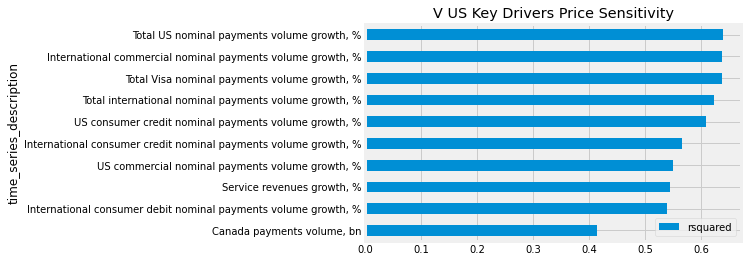

In [11]:
%matplotlib inline
df_kpi = cdr.regress_dataframe_time_series_groups(df_data = df_data,
                                         y_name=alpha_days,
                                         return_grouped=True,
                                         category = category_filter,
                                         n_periods=regression_window)
df_kpi = df_kpi[['ticker','time_series_description','time_series_name','category','rsquared']].head(10).sort_values('rsquared',ascending = True)
df_kpi.plot(x='time_series_description',y='rsquared',kind='barh',title=ticker+" Key Drivers Price Sensitivity")

We can see the price / time series history of the top KPI to check whether it makes sense

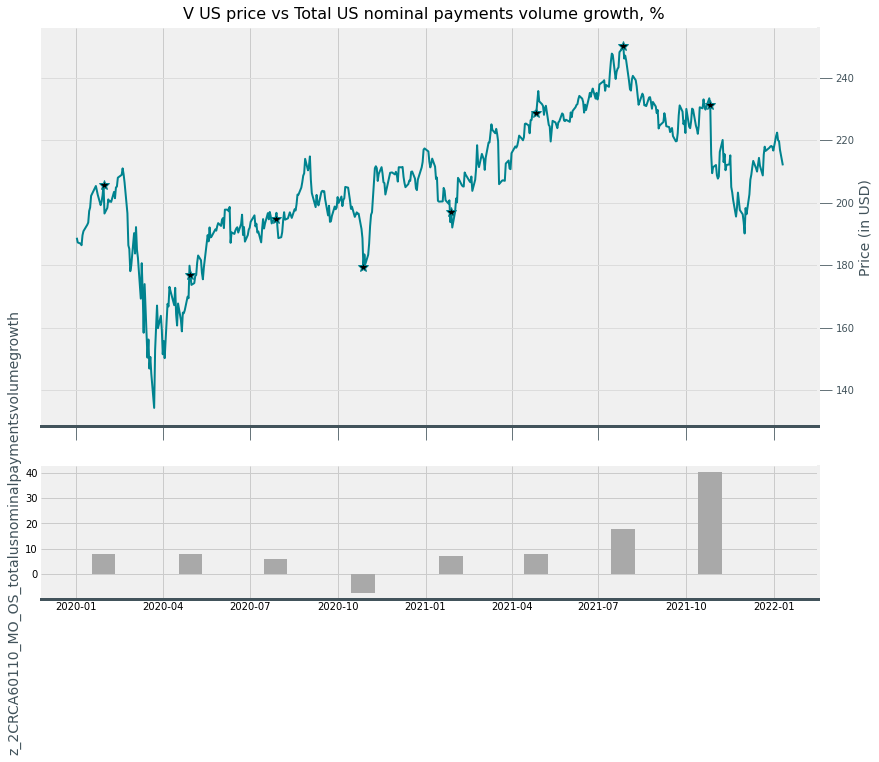

In [12]:
top_kpi = df_kpi.iloc[9]['time_series_name']
time_series_name=top_kpi
df_prices = cdr.get_price_data(yahoo_ticker, reset=True, rolling_betas=False, index_ticker=index_ticker)
cdr.plot_prices_against_time_series(df_data,df_prices,time_series_name,"value") #raw value

In a separate analysis, we can pull the key drivers off the precedent tree for revenue, and rank order their impact on revenue.

In [13]:

#use the same node tree to extract key drivers (red nodes)
df = model_set.models[ticker].key_driver_map("MO_RIS_REV")
return_series = 'MO_RIS_REV'
driver_list_df = []
for i, row in df.iterrows():

    time_series_name = row['time_series_name']
    print(f"scenario: move {time_series_name} 1% and get resultant change in {return_series}")

    #create a param dataframe for each time series name in our list
    df_1_param = model_set.forecast_frame(time_series_name,
                         n_periods=-1,
                         function_name='multiply',
                         function_value=1.01)


    d_output=model_set.fit(df_1_param,return_series) #our fit function will return a link to scenario engine JSON for audit

    df_output = model_set.filter_summary(d_output,period_type='Q')

    df_merge = pd.merge(df_output,df_1_param,how='inner',left_on=['ticker','period_name'],right_on=['ticker','period_name'])

    driver_list_df.append(df_merge) #append to a list for concatenating at the end
df = pd.concat(driver_list_df).sort_values('diff',ascending=False)
df = df.rename(columns={'time_series_name_y':'time_series_name'})
df['diff'] = df['diff']-1
df = df.sort_values('diff')


https://mds.canalyst.com/api/equity-model-series/2CRCA60110/equity-models/FY2021.23/time-series/MO_RIS_REV/forecast-data-points/Q1-2022/drivers/?format=dot
scenario: move z_2CRCA60110_MO_GA_DifferenceInternationalTransactionvsNominalCrossborderVolume 1% and get resultant change in MO_RIS_REV
V US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/2CRCA60110/equity-models/FY2021.23/scenarios/7xKQ9crcVe2aRlfIE5v0rA/
scenario: move z_2CRCA60110_MO_GA_ConstantCrossborderVolumeexclIntraEurope 1% and get resultant change in MO_RIS_REV
V US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/2CRCA60110/equity-models/FY2021.23/scenarios/J6eEFSSwVs6474WbEQnIIw/
scenario: move z_2CRCA60110_MO_GA_ImpliedFXimpactCrossborderVolumeexclIntraEurope 1% and get resultant change in MO_RIS_REV
V US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/2CRCA60110/equity-models/FY2021.23/scenarios/heZkvr_sU--8jzTStVhgIg/
scenario: move z_2CRCA60110_MO_OS_Otherrevenue

<AxesSubplot:title={'center':'V US Key Drivers Revenue Sensitivity'}, ylabel='time_series_description_y'>

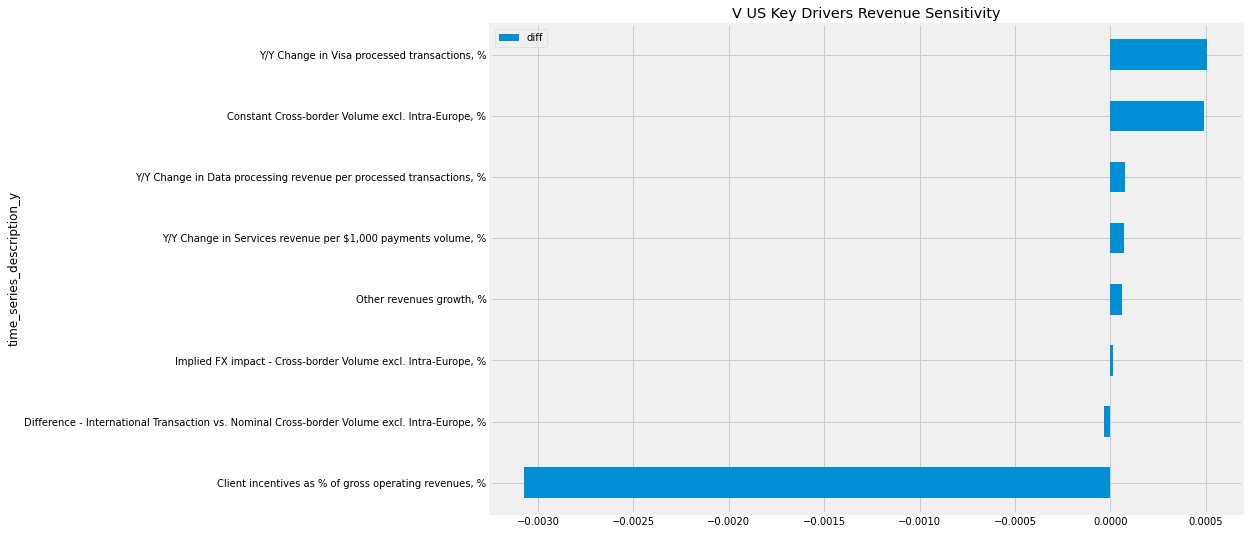

In [14]:
df.plot(x='time_series_description_y',y='diff',kind='barh',title=ticker+" Key Drivers Revenue Sensitivity")

In [15]:
os.path.exists(os.path.expanduser('~')+model_map.model_path)
#print(os.path.expanduser('~'))
model_map.model_path

NameError: name 'model_map' is not defined

In [ ]:
#model_set = cd.ModelSet(ticker_list=[ticker], config=config) #create a modelset of our ticker
time_series_name="MO_RIS_REV"
model_map = model_set.create_model_map(ticker=ticker,
                            time_series_name=time_series_name,
                            tree = True,
                            notebook = True,
                            col_for_labels = "time_series_description") 
from IPython.display import IFrame
map_file=ticker.split(' ')[0]+'_'+time_series_name+'_model_map.html'
display(IFrame('canalyst/'+map_file, width='100%', height='1000px'))

In [ ]:
df.sort_values('diff',ascending=False)

A configuration file has been created for you in 
/home/canalyst-candas/canalyst/keys.json. For Excel file downloads and scenario 
mapping, you'll need to add an API key to the 'canalyst_api_key' 
value. Visit https://app.canalyst.com/settings/api-tokens to create 
and retrieve your API key. You will also need to retrieve your 
S3 Access ID and Secret Key and fill in 'canalyst_s3_id' and 
'canalyst_s3_key' with those values, respectively. If using a 
Jupyter Notebook, stop and restart the notebook for the changes to 
take effect. If using a Python/iPython session, quit the current 
session and start a new one.
A configuration file has been created for you in 
/home/canalyst-candas/canalyst/keys.json. For Excel file downloads and scenario 
mapping, you'll need to add an API key to the 'canalyst_api_key' 
value. Visit https://app.canalyst.com/settings/api-tokens to create 
and retrieve your API key. You will also need to retrieve your 
S3 Access ID and Secret Key and fill in 'canalyst_s3